In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-10-31 11:26:45--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.161.168
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.161.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  56.6MB/s    in 0.2s    

2022-10-31 11:26:46 (56.6 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
# 기온예측문제
import pandas as pd
df = pd.read_csv('/content/jena_climate_2009_2016.csv')
df.head()

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.75     152.3  
1       1309.80      0.72           1.50     136.1  
2       1310.24      0.19           0.63     171.6  
3       1309.19      0.34           0.50     198.0  
4       1309.00      0.32           0.63     214.3

In [4]:
import os
fname = os.path.join('/content/jena_climate_2009_2016.csv')
with open(fname) as f:
  data = f.read()

lines = data.split('\n')

In [6]:
header = lines[0].split(',')
lines = lines[1:]

In [13]:
type(header)
type(df.columns.tolist())

list

In [65]:
# 데이터 파싱
import numpy as np
temperature = np.zeros((len(lines)))
raw_data = np.zeros((len(lines), len(header)-1  ))

In [66]:
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i,:] = values[:] 

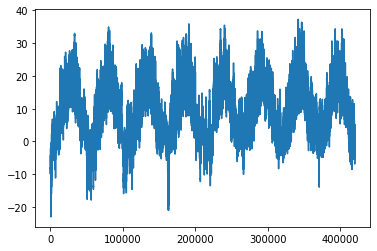

In [67]:
# 전체 기온을 그래프로 그리기
import matplotlib.pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

In [68]:
# 구간을 나눠서 시각화 해보기
6*24*10

1440

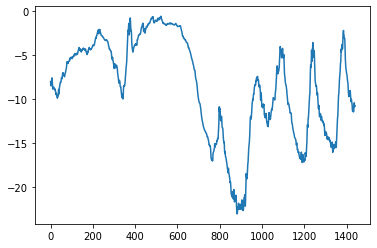

In [69]:
plt.plot(range(1440), temperature[:1440] )
plt.show()

In [70]:
split1 = int(len(raw_data)*0.5)
split2 = int(len(raw_data)*0.25)

train_samples =  raw_data[:split1]
val_samples = raw_data[split1:split1+split2]
test_samples = raw_data[split1+split2:]

In [71]:
len(raw_data)

420451

In [72]:
len(train_samples) , len(val_samples) , len(test_samples)

(210225, 105112, 105114)

In [73]:
# 데이터 정규화 train data
import copy
raw_data2 = copy.deepcopy(raw_data)
mean = train_samples.mean()
raw_data2 -= mean
std = train_samples.std()
raw_data2 /= std

In [75]:
from tensorflow import keras

In [76]:
int_sequence = np.arange(10)
int_sequence

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [78]:
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets = int_sequence[3:],
    sequence_length = 3,
    batch_size=2,
)

In [79]:
int_sequence[:-3],int_sequence[3:]

(array([0, 1, 2, 3, 4, 5, 6]), array([3, 4, 5, 6, 7, 8, 9]))

In [83]:
for inputs,targets in  dummy_dataset:
  print(inputs, targets)


tf.Tensor(
[[0 1 2]
 [1 2 3]], shape=(2, 3), dtype=int64) tf.Tensor([3 4], shape=(2,), dtype=int64)
tf.Tensor(
[[2 3 4]
 [3 4 5]], shape=(2, 3), dtype=int64) tf.Tensor([5 6], shape=(2,), dtype=int64)
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int64) tf.Tensor([7], shape=(1,), dtype=int64)


In [86]:
# 훈련,검증,테스트 데이터셋 만들기
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length+24-1)
batch_size = 256
train_dataset = keras.utils.timeseries_dataset_from_array(
    data = raw_data2[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    shuffle = True,
    batch_size = batch_size,
    sequence_length = sequence_length,
    start_index = 0,
    end_index = split1
)
val_dataset = keras.utils.timeseries_dataset_from_array(
    data = raw_data2[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    shuffle = True,
    batch_size = batch_size,
    sequence_length = sequence_length,
    start_index = split1,
    end_index = split1+split2
)
test_dataset = keras.utils.timeseries_dataset_from_array(
    data = raw_data2[:-delay],
    targets = temperature[delay:],
    sampling_rate = sampling_rate,
    shuffle = True,
    batch_size = batch_size,
    sequence_length = sequence_length,
    start_index = split1+split2    
)

In [89]:
for samples, targets in train_dataset:
  print(samples.shape, targets.shape)
  break


(256, 120, 14) (256,)
